# Predict steering angle with a simple ConvNet

In [1]:
import pandas as pd
import os, sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import train_util

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.models import load_model
from keras import metrics
import keras as K

Using TensorFlow backend.


# Loading Dataset

In [3]:
import pandas as pd

# steering_label2 = pd.read_csv("/home/ubuntu/dataset/udacity-driving-testing-ds/interpolated.csv")
steering_label2 = pd.read_csv("/Volumes/Personal_Drive/Datasets/Udacity_Self-Driving-Car/udacity-driving-testing-ds/interpolated.csv")
steering_labels = steering_label2
print(steering_labels.shape)
steering_labels.head()

(101396, 12)


,index,timestamp,width,height,frame_id,filename,angle,torque,speed,lat,long,alt
0,2016-11-17 23:10:15.873184606,1479424215873184606,640,480,left_camera,left/1479424215873184606.jpg,0.000360,0.375000,23.003350,37.545269,-122.326485,8.116664
1,2016-11-17 23:10:15.877284689,1479424215877284689,640,480,right_camera,right/1479424215877284689.jpg,0.000717,0.375000,23.003919,37.545269,-122.326485,8.123680
2,2016-11-17 23:10:15.880976321,1479424215880976321,640,480,center_camera,center/1479424215880976321.jpg,0.001039,0.375000,23.004431,37.545269,-122.326492,8.128418
3,2016-11-17 23:10:15.922817911,1479424215922817911,640,480,left_camera,left/1479424215922817911.jpg,0.003491,0.394737,23.007310,37.545261,-122.326500,8.139066
4,2016-11-17 23:10:15.927281227,1479424215927281227,640,480,right_camera,right/1479424215927281227.jpg,0.003491,0.380823,23.006074,37.545261,-122.326500,8.144778


# Test generator

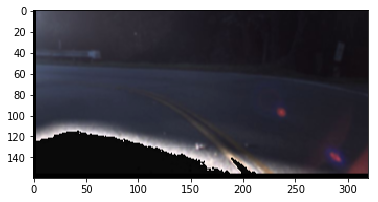

0.00702616763021


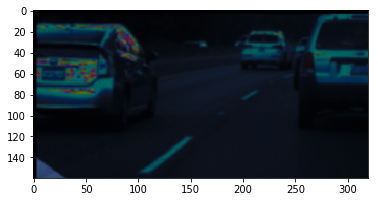

-0.0684226362894


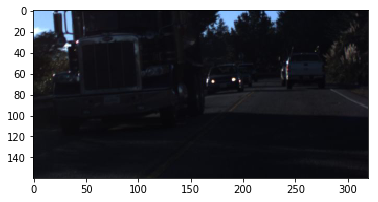

-0.144715461607


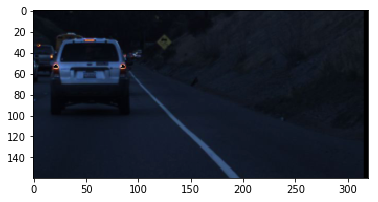

0.0298715030445


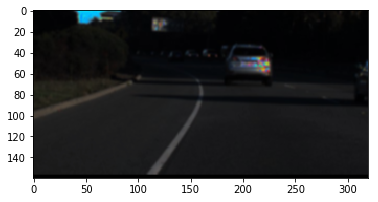

0.0977684492302


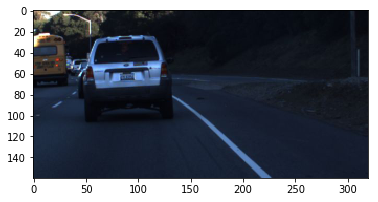

-0.0157079640776


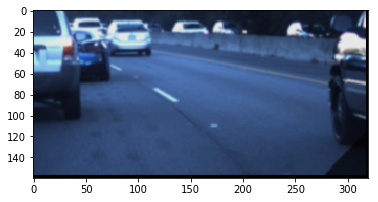

0.0936636454954


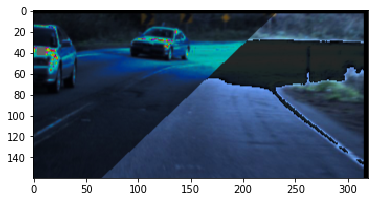

-0.0188340301728


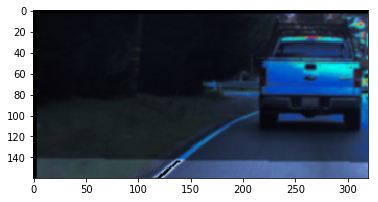

-0.0254337542492


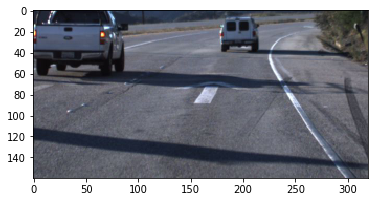

-0.123625238429


In [6]:
# testing the generator
# dir = "/home/ubuntu/dataset/udacity-driving-testing-ds/"
dir = "/Volumes/Personal_Drive/Datasets/Udacity_Self-Driving-Car/udacity-driving-testing-ds/"

training_gen = train_util.batch_generator(dir, steering_labels.values, 20, True)
batch_img, steering_angle = next(training_gen)

for i in range(10):
    im = np.array(batch_img[i], dtype=np.uint8)
    steering = steering_angle[i]
    plt.imshow(im)
    plt.show();
    print(steering)

/home/ubuntu/dataset/small-testing-ds/center/1479425441182877835.jpg
/home/ubuntu/dataset/small-testing-ds/center/1479425441232704425.jpg
/home/ubuntu/dataset/small-testing-ds/center/1479425441282730750.jpg
/home/ubuntu/dataset/small-testing-ds/center/1479425441332806714.jpg
/home/ubuntu/dataset/small-testing-ds/center/1479425441382790272.jpg
/home/ubuntu/dataset/small-testing-ds/center/1479425441432724303.jpg
/home/ubuntu/dataset/small-testing-ds/center/1479425441482746958.jpg
/home/ubuntu/dataset/small-testing-ds/center/1479425441532802506.jpg
/home/ubuntu/dataset/small-testing-ds/center/1479425441582725165.jpg
/home/ubuntu/dataset/small-testing-ds/center/1479425441632720892.jpg


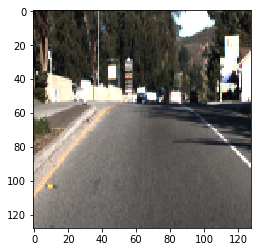

-0.0157079640776


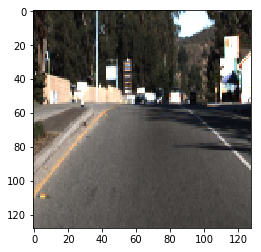

-0.0157079640776


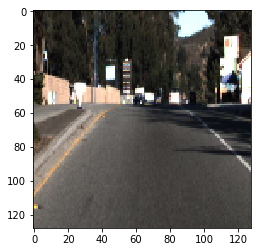

-0.0157079640776


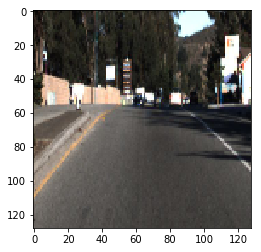

-0.0157079640776


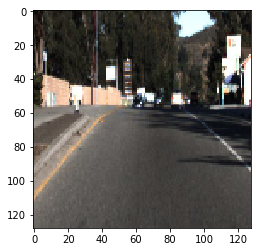

-0.0157079640776


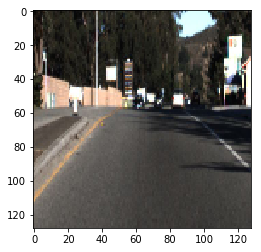

-0.0157079640776


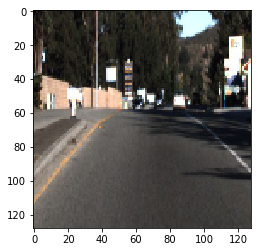

-0.0157079640776


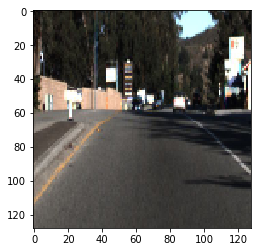

-0.0157079640776


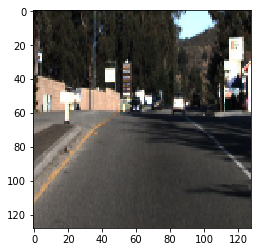

-0.0157079640776


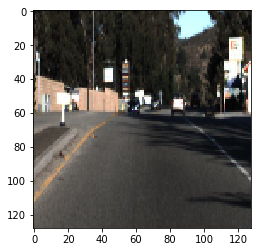

-0.0157079640776


In [3]:
val_dir = "/home/ubuntu/dataset/small-testing-ds/"
val_labels = pd.read_csv(val_dir + "interpolated.csv")

validation_gen = train_util.validation_generator(val_dir, val_labels, 10)
imgs, steers = next(validation_gen)

for i in range(10):
    im = np.array(imgs[i], dtype=np.uint8)
    steering = steers[i]
    plt.imshow(im)
    plt.show();
    print(steering)

# ConvNets

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.backend.sqrt(K.backend.mean(K.backend.square(y_pred - y_true), axis=-1)) 

In [ ]:
def create_comma_model_prelu():
    model = Sequential()

    model.add(Conv2D(16, 8, 8, subsample=(4, 4), border_mode="same", input_shape=(480, 640, 3)))
    model.add(PReLU())
    model.add(Conv2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(PReLU())
    model.add(Conv2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    #model.add(Dropout(.5))
    model.add(PReLU())
    model.add(Dense(512))
    #model.add(Dropout(.5))
    model.add(PReLU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    print('Model is created and compiled..')
    return model

In [ ]:
def create_nvidia_model():
    model = Sequential()

    model.add(Conv2D(24, (5, 5), padding="same", strides = 2, input_shape=(480, 640, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(36, (5, 5), padding="same", strides = 2))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (5, 5), padding="same", strides = 2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding="same", strides = 2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding="same", strides = 2))
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(1))
    adam = Adam(lr=1e-4)
    model.compile(optimizer=adam, loss=root_mean_squared_error)

    print('Model is created and compiled..')
    return model

In [ ]:
model = create_nvidia_model()
model.summary()

In [ ]:
model.fit_generator(train_util.batch_generator(dir, steering_labels.values, 8, True),
                    steps_per_epoch=2000, epochs=10, verbose=1,
                    validation_data=train_util.batch_generator(dir, steering_labels.values, 2, False),
                    validation_steps=200)

In [ ]:
model.save("trained2_v1.h5")
# testing the results
#model = load_model('trained-v4.h5')
predictions = model.predict(batch_img)

for i in range(20):
    im = np.array(batch_img[i], dtype=np.uint8)
    plt.imshow(im)
    plt.show();
    print(steering_angle[i])
    print(predictions[i])